Requires notebook 1.

In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(ggnewscale)
  library(ggplot2)
  library(ggrastr)
  library(readr)
  library(viridis)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [ ]:
# load the precomputed marker genes
markers <- DatasetPath('nsclc_rna', 'nsclc_markers_list_full.tsv') %>%
  read.table(sep = '\t',header=TRUE)
tumor_marker_genes <- markers$Gene[markers$cluster=='malignant']
macro_marker_genes <- markers$Gene[markers$cluster=='macrophage']
fibroblast_marker_genes <- markers$Gene[markers$cluster=='fibroblast']

In [3]:
cell_annot <- prepare_nsclc_metadata(
  ct_annot=FALSE)
print(head(cell_annot[,c('cell','x','y','celltype','niche')]))

           cell        x        y    celltype                       niche
c_1_1_1 c_1_1_1 28.78886 -3.28806         mDC plasmablast-enriched stroma
c_1_1_2 c_1_1_2 29.12672 -3.29040 endothelial                      stroma
c_1_1_3 c_1_1_3 29.32868 -3.28878 endothelial                      stroma
c_1_1_4 c_1_1_4 29.36540 -3.29418         pDC                      stroma
c_1_1_5 c_1_1_5 29.37044 -3.28842  macrophage                      stroma
c_1_1_7 c_1_1_7 28.73252 -3.29292  macrophage plasmablast-enriched stroma


In [4]:
dial_res <- DatasetPath('nsclc', 'DIALOGUE1_LungCancer.SMI.rds') %>% readRDS()

# plotting cell scores on top of cells
cell_annot$all_scores <- NA
fib_scores <- dial_res[["cca.scores"]][["fibroblast"]][,'MCP1']
cell_annot[names(fib_scores),'all_scores'] <- fib_scores
mac_scores <- dial_res[["cca.scores"]][["macrophage"]][,'MCP1']
cell_annot[names(mac_scores),'all_scores'] <- mac_scores
cd4_scores <- dial_res[["cca.scores"]][["T.CD4"]][,'MCP1']
cell_annot[names(cd4_scores),'all_scores'] <- cd4_scores

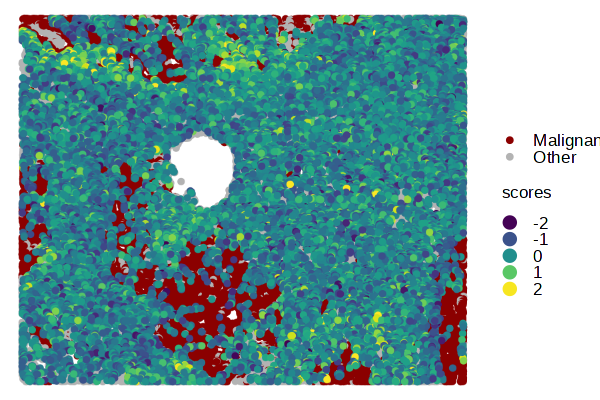

In [25]:
options(repr.plot.width = 3, repr.plot.height = 2, repr.plot.res = 200)

# outlier cells mess up the coloring gradient, so assigning them to the top score of non-outliers
ndx_outliers1 <- which(cell_annot$all_scores>sd(cell_annot$all_scores,na.rm = T)*3)
ndx_not_outliers1 <- which(cell_annot$all_scores<sd(cell_annot$all_scores,na.rm = T)*3)
max_no_outliers <- max(cell_annot$all_scores[ndx_not_outliers1])
cell_annot$all_scores[ndx_outliers1] <- max_no_outliers
ndx_outliers1 <- which(cell_annot$all_scores<(-sd(cell_annot$all_scores,na.rm = T)*3))
ndx_not_outliers1 <- which(cell_annot$all_scores>(-sd(cell_annot$all_scores,na.rm = T)*3))
min_no_outliers <- min(cell_annot$all_scores[ndx_not_outliers1])
cell_annot$all_scores[ndx_outliers1] <- min_no_outliers
cell_annot$is_malignant <- factor(cell_annot$celltype=='malignant',levels=c(TRUE,FALSE))
levels(cell_annot$is_malignant) <- c('Malignant','Other')
cell_annot_no_color <- cell_annot[is.na(cell_annot$all_scores),]
cell_annot_color <- cell_annot[!is.na(cell_annot$all_scores),]
p <- ggplot(cell_annot_no_color,aes(x=x,y=y,color=is_malignant)) +
  geom_point_rast(size=gg_point_size/2) +
  scale_color_manual(name="",,na.translate = FALSE,values = c(
    "Malignant" = "red4",
    "Other" = "grey70"
  )) +
  legend_mod +
  new_scale_color() +
  geom_point_rast(data=cell_annot_color,aes(x=x,y=y,color=all_scores),size=gg_point_size/2) +
#   ggtitle('Fibroblasts, macrophages, and CD4 T MCP1 scores') +
  scale_color_viridis(discrete = FALSE,na.value="grey70",name="scores") +
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5,size=6),
        text = element_text(family = font_choice),
        legend.text=element_text(size=6),
        legend.title=element_text(size=6),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(6, 'pt'))

p

In [26]:
# getting height width ratio to keep aspect ratio accurate in the pdf
x_diff <- diff(range(cell_annot$x, na.rm=TRUE))
y_diff <- diff(range(cell_annot$y, na.rm=TRUE))
aspect_ratio <- y_diff / x_diff

width_plot <- 2.25
height_plot <- aspect_ratio * width_plot
print(height_plot)

[1] 1.800551


In [27]:
pdf(OutputPath("nsclc_mcp1_scores.pdf"), useDingbats=FALSE, width=width_plot, height=height_plot)
p + theme(legend.position="none")
dev.off()

png 
  2

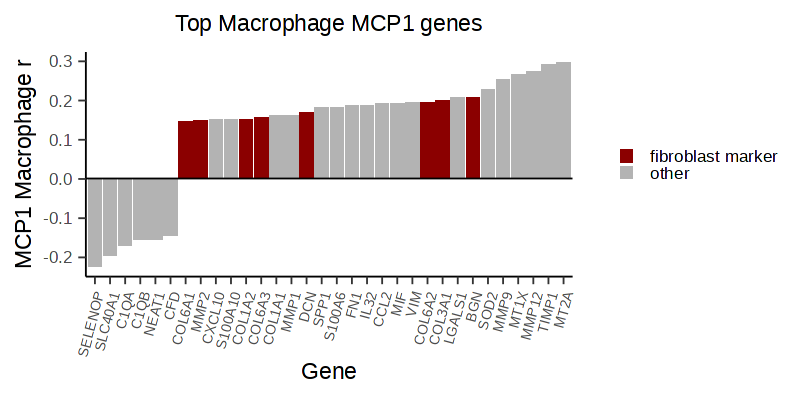

In [28]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 200)

### plottin gene-mcp correlations with marker annotations
# select dialogue significant genes for MCP1 in macrophages
g_select <- c(dial_res[["cca.sig"]][["macrophage"]][["MCP1.up"]],dial_res[["cca.sig"]][["macrophage"]][["MCP1.down"]])

# extract factor correlations for these genes
macro_lds <- dial_res[["cca.gene.cor"]][["macrophage"]][["R"]]
macro_lds <- macro_lds[g_select,]
# select top n to have smaller list to show
n = 32
top_n_g <- rownames(macro_lds)[order(abs(macro_lds[,1]),decreasing=TRUE)[1:n]]
macro_lds <- macro_lds[top_n_g,]
tmp <- as.data.frame(macro_lds[,'MCP1',drop=FALSE])
g_ordered <- rownames(tmp)[order(tmp$MCP1,decreasing=FALSE)]
tmp$bar_order <- factor(rownames(tmp),levels=g_ordered)
tmp$marker <- sapply(rownames(tmp),function(x){
  if (x %in% fibroblast_marker_genes) {
    return('fibroblast marker')
  } else if (x %in% tumor_marker_genes) {
    return('tumor marker')
  } else {
    return('other')
  }
})
myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=bar_order,y=MCP1,fill=marker)) +
  geom_col() +
  geom_hline(yintercept = 0,linewidth=gg_line_thickness) +
  ggtitle('Top Macrophage MCP1 genes') +
  xlab('Gene') +
  ylab('MCP1 Macrophage r') +
  scale_fill_manual(breaks = c('fibroblast marker','tumor marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank(),
       axis.text.x = element_text(angle = 75, vjust = 1, hjust=1,size=5),
       legend.text=element_text(size=6),
       legend.key.size = unit(6, 'pt'),
       legend.key.height = unit(6, 'pt'),
       legend.key.width = unit(6, 'pt'))

p

In [29]:
pdf(OutputPath("nsclc_mcp1_fib_markers.pdf"), useDingbats = FALSE, width = 4, height = 2)
p
dev.off()

png 
  2

In [30]:
## run fgsea
tester = dial_res[["cca.gene.cor"]][["macrophage"]][["R"]]
mystats <- tester[,1]
names(mystats) <- rownames(tester)
set_list <- list(tumor_marker_genes,fibroblast_marker_genes)
names(set_list) <- c('tumor_markers','fibroblast_markers')
fgsea_res <- fgsea::fgseaSimple(pathways = set_list,
                              stats = mystats,
                              minSize=5,
                              nperm=10000)
print(head(fgsea_res))

              pathway         pval         padj        ES      NES nMoreExtreme
               <char>        <num>        <num>     <num>    <num>        <num>
1: fibroblast_markers 0.0005271481 0.0005271481 0.6519471 1.904274            3
    size  leadingEdge
   <int>       <list>
1:    24 BGN, COL....


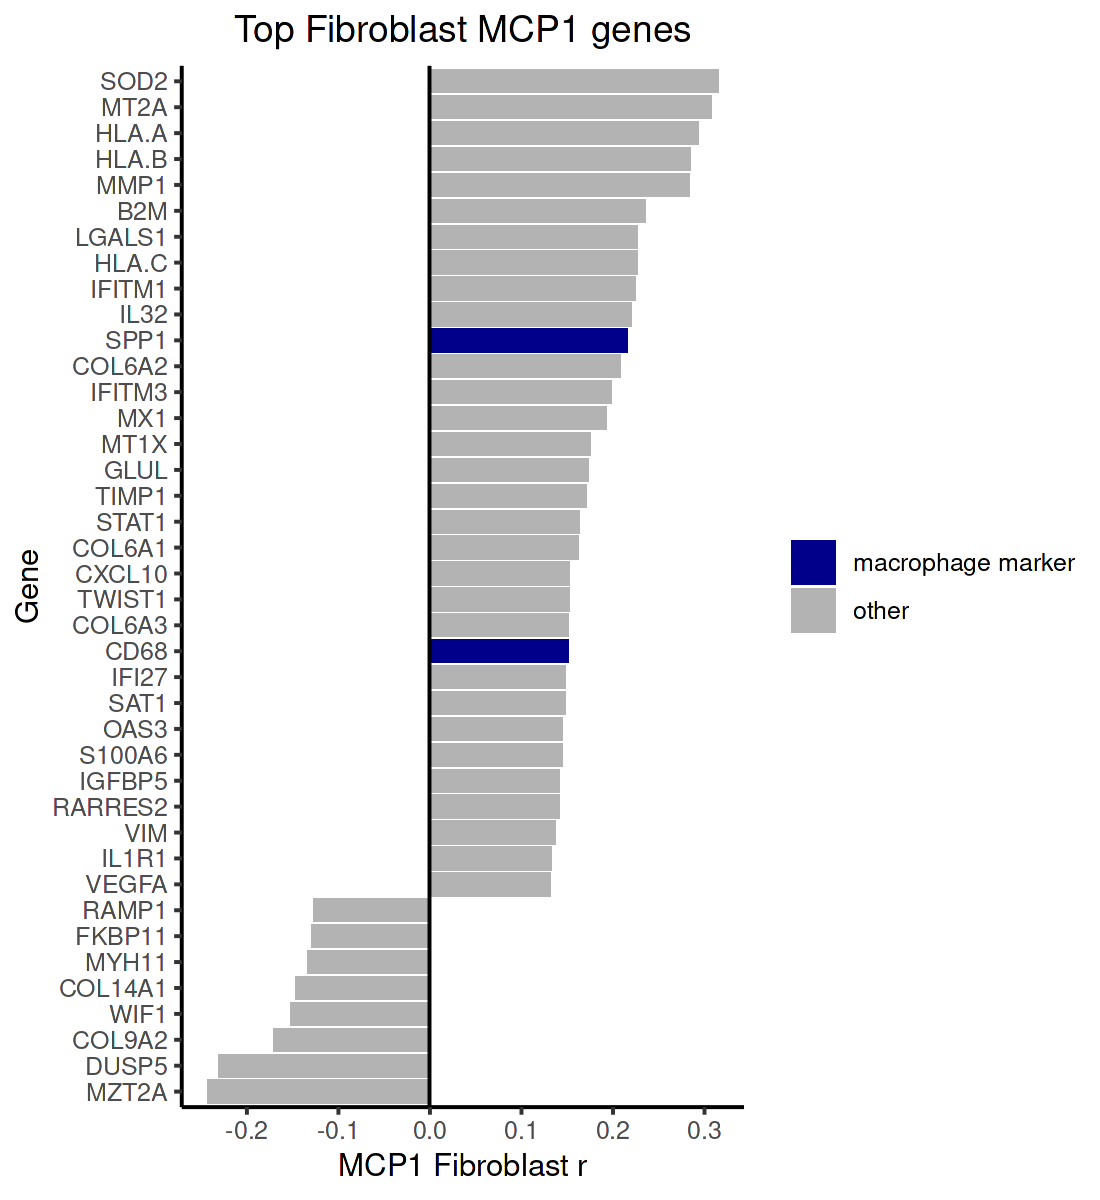

In [31]:
options(repr.plot.width = 5.5, repr.plot.height = 6, repr.plot.res = 200)

### plottin gene-mcp correlations with marker annotations
# select dialogue significant genes for MCP1 in fibroblasts
g_select <- c(dial_res[["cca.sig"]][["fibroblast"]][["MCP1.up"]],dial_res[["cca.sig"]][["fibroblast"]][["MCP1.down"]])

# extract factor correlations for these genes
macro_lds <- dial_res[["cca.gene.cor"]][["fibroblast"]][["R"]]
macro_lds <- macro_lds[g_select,]
# select top n to have smaller list to show
n = 40
top_n_g <- rownames(macro_lds)[order(abs(macro_lds[,1]),decreasing=TRUE)[1:n]]
macro_lds <- macro_lds[top_n_g,]
tmp <- as.data.frame(macro_lds[,'MCP1',drop=FALSE])
g_ordered <- rownames(tmp)[order(tmp$MCP1,decreasing=FALSE)]
tmp$bar_order <- factor(rownames(tmp),levels=g_ordered)
tmp$marker <- sapply(rownames(tmp),function(x){
    if (x %in% macro_marker_genes) {
        return('macrophage marker')
    } else if (x %in% tumor_marker_genes) {
        return('tumor marker')
    } else {
        return('other')
    }
})

myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=bar_order,y=MCP1,fill=marker)) +
  geom_col() +
  coord_flip() +
  geom_hline(yintercept = 0) +
  ggtitle('Top Fibroblast MCP1 genes') +
  xlab('Gene') +
  ylab('MCP1 Fibroblast r') +
  scale_fill_manual(breaks = c('tumor marker','macrophage marker','other'), values = myColors) +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank())

p

In [32]:
## run fgsea
tester = dial_res[["cca.gene.cor"]][["fibroblast"]][["R"]]
mystats <- tester[,1]
names(mystats) <- rownames(tester)
set_list <- list(tumor_marker_genes,macro_marker_genes)
names(set_list) <- c('tumor_markers','macrophage_markers')
fgsea_res <- fgsea::fgseaSimple(pathways = set_list,
                              stats = mystats,
                              minSize=5,
                              nperm=10000)
print(head(fgsea_res))

              pathway      pval      padj         ES       NES nMoreExtreme
               <char>     <num>     <num>      <num>     <num>        <num>
1:      tumor_markers 0.3673681 0.3673681 -0.5166914 -1.093633         1413
2: macrophage_markers 0.1282565 0.2565130  0.6310118  1.343705          831
    size  leadingEdge
   <int>       <list>
1:     5 KRT6A, C....
2:     7 SPP1, CD....


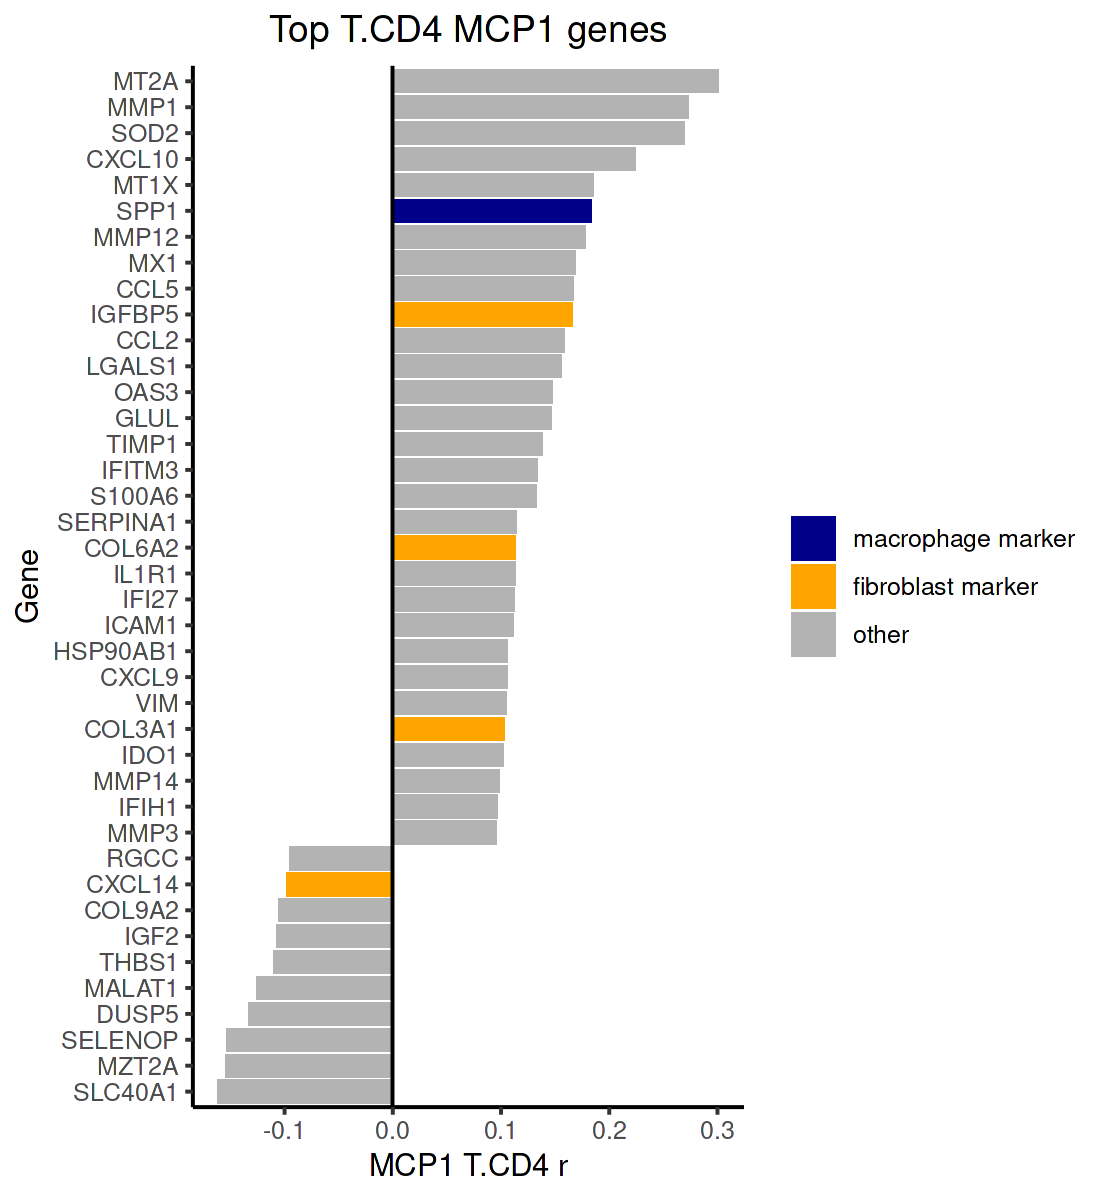

In [33]:
options(repr.plot.width = 5.5, repr.plot.height = 6, repr.plot.res = 200)

### plottin gene-mcp correlations with marker annotations
# select dialogue significant genes for MCP1 in T.CD4
g_select <- c(dial_res[["cca.sig"]][["T.CD4"]][["MCP1.up"]],dial_res[["cca.sig"]][["T.CD4"]][["MCP1.down"]])

# extract factor correlations for these genes
macro_lds <- dial_res[["cca.gene.cor"]][["T.CD4"]][["R"]]
macro_lds <- macro_lds[g_select,]
# select top n to have smaller list to show
n = 40
top_n_g <- rownames(macro_lds)[order(abs(macro_lds[,1]),decreasing=TRUE)[1:n]]
macro_lds <- macro_lds[top_n_g,]
tmp <- as.data.frame(macro_lds[,'MCP1',drop=FALSE])
g_ordered <- rownames(tmp)[order(tmp$MCP1,decreasing=FALSE)]
tmp$bar_order <- factor(rownames(tmp),levels=g_ordered)
tmp$marker <- sapply(rownames(tmp),function(x){
    if (x %in% macro_marker_genes) {
        return('macrophage marker')
    } else if (x %in% tumor_marker_genes) {
        return('tumor marker')
    } else if (x %in% fibroblast_marker_genes) {
        return('fibroblast marker')
    } else {
        return('other')
    }
})

myColors <- c('red4','blue4','orange','grey70')
p <- ggplot(tmp,aes(x=bar_order,y=MCP1,fill=marker)) +
  geom_col() +
  coord_flip() +
  geom_hline(yintercept = 0) +
  ggtitle('Top T.CD4 MCP1 genes') +
  xlab('Gene') +
  ylab('MCP1 T.CD4 r') +
  scale_fill_manual(breaks = c('tumor marker','macrophage marker','fibroblast marker','other'), values = myColors) +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank())

p

In [34]:
## run fgsea
tester = dial_res[["cca.gene.cor"]][["T.CD4"]][["R"]]
mystats <- tester[,1]
names(mystats) <- rownames(tester)
set_list <- list(tumor_marker_genes,fibroblast_marker_genes,macro_marker_genes)
names(set_list) <- c('tumor_markers','fibroblast_markers','macrophage_markers')
fgsea_res <- fgsea::fgseaSimple(
  pathways = set_list, stats = mystats, minSize=5, nperm=10000
)
print(head(fgsea_res))

              pathway      pval      padj        ES       NES nMoreExtreme
               <char>     <num>     <num>     <num>     <num>        <num>
1: fibroblast_markers 0.5512689 0.5512689 0.3128015 0.9403145         4300
2: macrophage_markers 0.3244172 0.5512689 0.4819391 1.1289489         2170
    size  leadingEdge
   <int>       <list>
1:    25 IGFBP5, ....
2:     9 SPP1, MM....


[1] 6.811823e-37

Warning message:
“Removed 1757 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


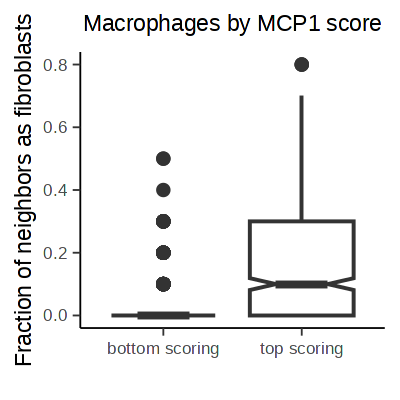

In [ ]:
options(repr.plot.width = 2, repr.plot.height = 2, repr.plot.res = 200)

## now computing average malignant adjacencies per cell
knn_kval <- 10
cell_annot <- cell_annot[!is.na(cell_annot$x),]
all_knn = cell_annot %>% select(x, y) %>% FNN::get.knn(k = knn_kval) %>% .$nn.index
rownames(all_knn) <- rownames(cell_annot)

cells_keep <- rownames(cell_annot)[cell_annot$celltype=='macrophage']
fracs_fib <- sapply(cells_keep,function(mycell) {
  nearest_cells <- all_knn[mycell,]
  return(sum(cell_annot[nearest_cells,'celltype']=='fibroblast')/knn_kval)
})

cell_annot$fracs_fib <- NA
cell_annot[names(fracs_fib),'fracs_fib'] <- fracs_fib

# trying to stratify by top/bottom 10th percent of macrophages by score
qs <- quantile(cell_annot$all_scores,probs = c(.05,.95),na.rm = TRUE)
top_ndx <- which(cell_annot$all_scores>qs[2])
cell_annot_top <- cell_annot[top_ndx,]
bot_ndx <- which(cell_annot$all_scores<qs[1])
cell_annot_bot <- cell_annot[bot_ndx,]

cell_annot_top$sc_discrete <- 'top scoring'
cell_annot_bot$sc_discrete <- 'bottom scoring'

tmp <- rbind.data.frame(cell_annot_top,cell_annot_bot)

p <- ggplot(tmp,aes(x=sc_discrete,y=fracs_fib)) +
  geom_boxplot(notch = TRUE) +
  ylab('Fraction of neighbors as fibroblasts') +
  xlab('') +
  ggtitle('Macrophages by MCP1 score') +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5))

tres <- t.test(cell_annot_top$fracs_fib,cell_annot_bot$fracs_fib)
tres[["p.value"]]

p

In [36]:
pdf(OutputPath("nsclc_mcp1_frac_fibs.pdf"), useDingbats=FALSE, width=2, height=2)
p
dev.off()

Warning message:
“Removed 1757 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


png 
  2